In [7]:
from models import NetworkedRENs, REN, RNNModel
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
from os.path import dirname, join as pjoin
import torch
from torch import nn

In [8]:
dtype = torch.float
device = torch.device("cpu")

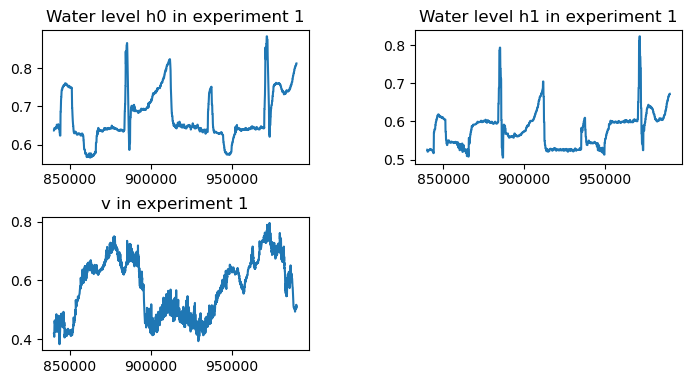

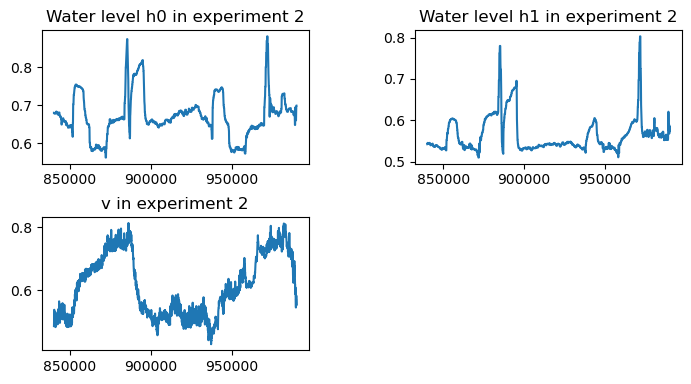

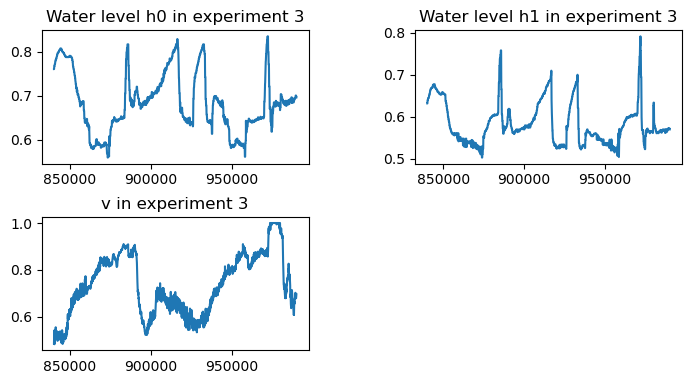

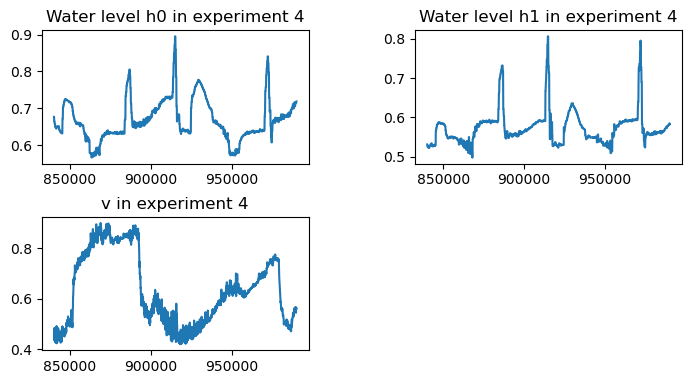

In [9]:
# Import Data
folderpath = os.getcwd()
filepath = pjoin(folderpath, 'input_3.mat')#'dataset_sysID_3tanks.mat')
data_in = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'output_Q_3.mat')
data_out = scipy.io.loadmat(filepath)
filepath = pjoin(folderpath, 'subsystems.mat')
data_sub = scipy.io.loadmat(filepath)

filepath = pjoin(folderpath, 'denormalize.mat')
data_max = scipy.io.loadmat(filepath)

# Extract data from dictionary
maxTrit, maxTdel, maxTabs, maxTchill = data_max['maxTrit'], data_max['maxTman'], data_max['maxTabs'], data_max['maxTchill']
Toutass_t, Toutass_v, Toutchill_t, Toutchill_v = data_sub['Toutass_train'], data_sub['Toutass_val'], data_sub['Toutchillers_train'], data_sub['Toutchillers_val']
dExp, yExp, dExp_val, yExp_val, time__, buildtot, buildtot_val = data_in['dExp'], data_out['yExp'], \
    data_in['dExp_val'], data_out['yExp_val'], data_in['time__'], data_out['buildtotnorm'], data_out['buildtotnorm_val']
nExp = yExp.size

t = time__

t_end = t.size

#initialize the model

ny = np.shape(yExp[0,-1])[1]
nd = np.shape(dExp[0,-1])[1]

#t = np.arange(0, np.size(dExp[0, 0], 1) * Ts-Ts, Ts)
#t_end = yExp[0, 0].shape[1] - 1

for exp in range(nExp):
    y_exp = yExp[0,exp]
    d_exp = dExp[0,exp]
    plt.figure(figsize=(4 * 2, 4))
    for out in range(ny):
        plt.subplot(2, 2, out+1)
        plt.plot(t[14000:16500], y_exp[14000:16500,out])
        plt.title(r"Water level h%i "%out + r"in experiment %i"%(exp+1))
    plt.subplot(2, 2, ny+1)
    plt.plot(t[14000:16500], d_exp[14000:16500,1])
    plt.title(r"v in experiment %i"%(exp+1))
    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.4)
plt.show()

Epoch: 1 	||	 Loss: 0.03497576341032982
L2 gain REN: 1
Epoch: 2 	||	 Loss: 0.0036538683343678713
L2 gain REN: 1
Epoch: 3 	||	 Loss: 0.009996590204536915
L2 gain REN: 1


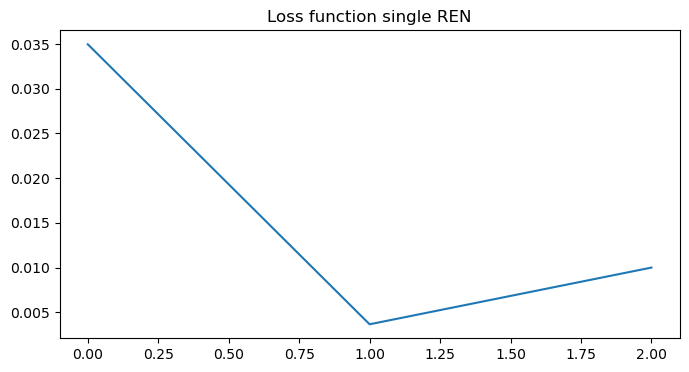

In [ ]:
# Train single REN ABSORBER
epochs = 3
t_end = 2*1440

n = 2  # input dimensions
p = 1  # output dimensions

n_xi = 20# nel paper n1, numero di stati
l = 20 # nel paper q, dimension of the square matrix D11 -- number of _non-linear layers_ of the RE
# Define the model
RENsys = REN(n, p, n_xi, l, gammaTrain = False, gamma= 1)
# Define Loss function
MSE = nn.MSELoss()
# Define Optimization method
learning_rate = 1.0e-1
optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
optimizer.zero_grad()

LOSSVAL = np.zeros(epochs)
LOSS = np.zeros(epochs)

yval = torch.from_numpy(Toutass_v[3 * 1440: 5* 1440]).float().to(device) #Toutass
yval = yval.T

yRENm_val = torch.zeros(p, t_end, device=device, dtype=dtype)
yRENm_val[:,0] = yval[:,0]
xiVal = torch.randn(n_xi)
dval = torch.cat(( torch.from_numpy(yExp_val[0,0][3* 1440 +1:5* 1440,0]).float().to(device).unsqueeze(1), #T_rit
                        torch.from_numpy(dExp_val[0, 0][3* 1440 +1:5* 1440,-1]).float().to(device).unsqueeze(1)), dim=1) # Qabs
dval= dval.T

for epoch in range(epochs):
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-2
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0
    for exp in range(nExp*3):
        # one week = 10080
        # one day = 1440
        # take data of every week between 4 and 5
        y = torch.from_numpy(Toutass_t[exp*10080 +3 * 1440:exp*10080 + 5* 1440]).float().to(device) #Toutass
        y = y.T
        yRENm = torch.randn(p, t_end, device=device, dtype=dtype)
        yRENm[:,0] = y[:,0]
        xi = torch.randn(n_xi)

        d = torch.cat(( torch.from_numpy(yExp[0, int(np.floor(exp/3))][(exp%3)*10080 +3* 1440 +1:(exp%3)*10080 + 5* 1440,0]).float().to(device).unsqueeze(1),#T_rit
                        torch.from_numpy(dExp[0, int(np.floor(exp/3))][(exp%3)*10080 +3* 1440 +1:(exp%3)*10080 + 5* 1440,-1]).float().to(device).unsqueeze(1)), dim=1)#Q_abs
                       
        d = d.T
        for t in range(1, t_end):
            #u = torch.tensor([d[inputnumberD, t]])
            yRENm[:, t], xi = RENsys(d[:,t-1], xi, t)
        loss = loss + MSE(yRENm[:, 0:yRENm.size(1)], y[:, 0:t_end + 1])
        # ignorare da loss effetto condizione iniziale
        
        loss_val = 0
    for t in range(1, t_end):
        yRENm_val[:, t], xiVal = RENsys(dval[:,t-1], xiVal, t)
    loss_val = loss_val + MSE(yRENm_val[:, 0:yRENm_val.size(1)], yval[:, 0:t_end + 1])

    LOSSVAL[epoch] = loss_val 
    loss = loss / 3/nExp
    #loss.backward()
    loss.backward(retain_graph=True)

    optimizer.step()
    RENsys.set_param()

    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    print(f"L2 gain REN: {RENsys.gamma}")
    LOSS[epoch] = loss

plt.figure(figsize=(4 * 2, 4))
plt.plot(LOSS)
plt.title("Loss function single REN")
plt.show()



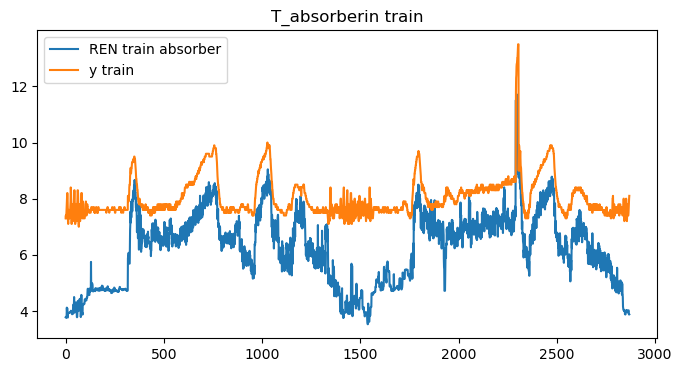

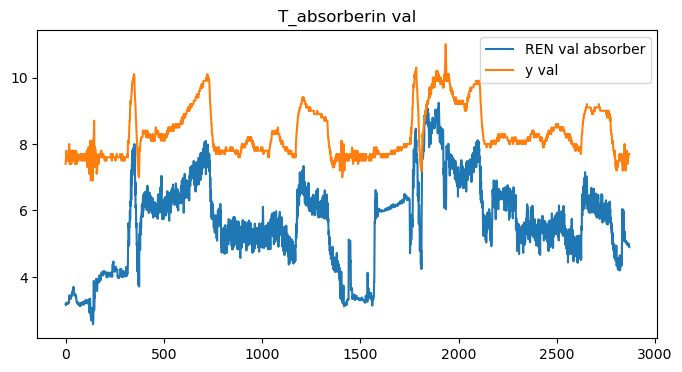

Loss Validation single REN absorber: 0.027837933972477913


In [ ]:
yval = torch.from_numpy(Toutass_v[3 * 1440: 5* 1440]).float().to(device) #Toutass
yval = yval.T

yRENm_val = torch.zeros(p, t_end, device=device, dtype=dtype)
yRENm_val[:,0] = yval[:,0]
xiVal = torch.randn(n_xi)
dval = torch.cat(( torch.from_numpy(yExp_val[0,0][3* 1440 +1:5* 1440,0]).float().to(device).unsqueeze(1), #T_rit
                        torch.from_numpy(dExp_val[0, 0][3* 1440 +1:5* 1440,-1]).float().to(device).unsqueeze(1)), dim=1) # Qabs
dval= dval.T
loss_val = 0
for t in range(1, t_end):
    yRENm_val[:, t], xiVal = RENsys(dval[:,t-1], xiVal, t)
loss_val = loss_val + MSE(yRENm_val[:, 0:yRENm_val.size(1)], yval[:, 0:t_end + 1])

loss_val_REN = loss_val

plt.figure(figsize=(4 * 2, 4))
for out in range(p):
    plt.subplot(1, p, out+1)
    plt.plot(maxTabs.squeeze()*yRENm[out, 10:t_end].detach().numpy(), label='REN train absorber')
    plt.plot(maxTabs.squeeze()*y[out, 10:t_end].detach().numpy(), label='y train')
    plt.title(r"T_absorber" + r"in train")  
    plt.legend()
plt.show()

plt.figure(figsize=(4 * 2, 4))
for out in range(p):
    plt.subplot(1, p, out+1)
    plt.plot(maxTabs.squeeze()*yRENm_val[out, 10:t_end].detach().numpy(), label='REN val absorber')
    plt.plot(maxTabs.squeeze()*yval[out, 10:t_end].detach().numpy(), label='y val')
    plt.title(r"T_absorber" + r"in val")  
    plt.legend()
plt.show()

pytorch_total_params_singleREN = sum(p.numel() for p in RENsys.parameters() if p.requires_grad)
print(f"Loss Validation single REN absorber: {loss_val_REN}")

# Save
torch.save({
    'epoch': epoch,
    'model_state_dict': RENsys.state_dict(),
    'loss': loss,
}, f'checkpoint_moreexp_absorber_epoch_{epoch+1}.pth')

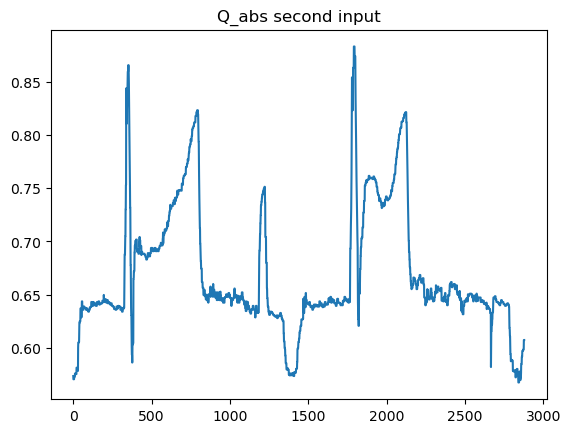

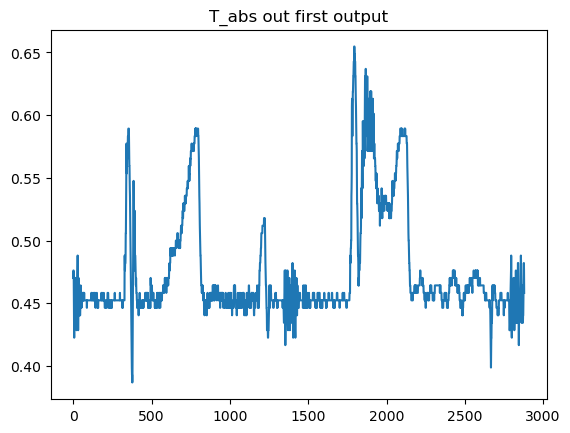

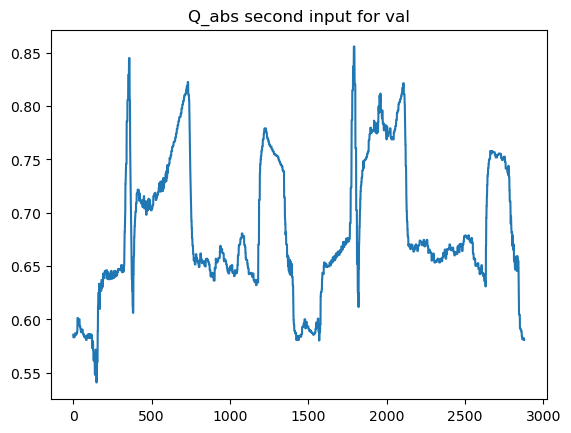

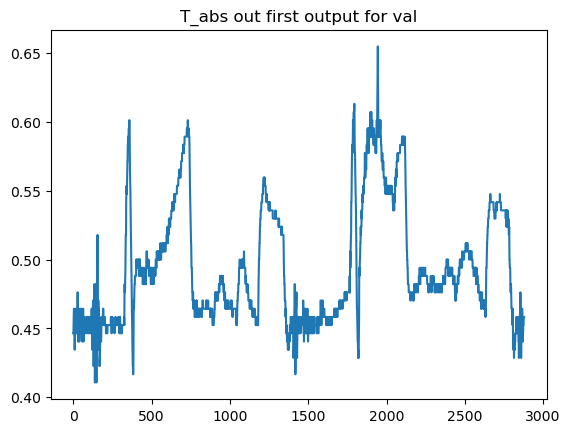

In [12]:
d = torch.cat(( torch.from_numpy(yExp[0, 0][10080 +3* 1440 +1:10080 + 5* 1440,0]).float().to(device).unsqueeze(1),#T_rit
                        torch.from_numpy(dExp[0, 0][10080 +3* 1440 +1:10080 + 5* 1440,-1]).float().to(device).unsqueeze(1)), dim=1)#Q_abs
dval = torch.cat(( torch.from_numpy(yExp_val[0,0][3* 1440 +1:5* 1440,0]).float().to(device).unsqueeze(1), #T_rit
                        torch.from_numpy(dExp_val[0, 0][3* 1440 +1:5* 1440,-1]).float().to(device).unsqueeze(1)), dim=1) # Qabs
y = torch.from_numpy(Toutass_t[10080 +3 * 1440: 10080 +5* 1440]).float().to(device) #Toutass
yval = torch.from_numpy(Toutass_v[3 * 1440: 5* 1440]).float().to(device) #Toutass

plt.plot(d[:,0])
plt.title("Q_abs second input")
plt.show()
plt.plot(y[:])
plt.title("T_abs out first output")
plt.show()
plt.plot(dval[:,0])
plt.title("Q_abs second input for val")
plt.show()
plt.plot(yval[:])
plt.title("T_abs out first output for val")
plt.show()

In [ ]:
# Train single REN ABSORBER adding two days per exp 
epochs = 3
t_end = 4*1440

n = 2  # input dimensions
p = 1  # output dimensions

n_xi = 20# nel paper n1, numero di stati
l = 20# nel paper q, dimension of the square matrix D11 -- number of _non-linear layers_ of the RE
# Define the model
RENsys = REN(n, p, n_xi, l, gammaTrain = False, gamma= 1)
# Define Loss function
MSE = nn.MSELoss()
# Define Optimization method
learning_rate = 1.0e-1
optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
optimizer.zero_grad()

LOSS = np.zeros(epochs)

for epoch in range(epochs):
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-2
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0
    for exp in range(nExp):
        # one week = 10080
        # one day = 1440
        # take data of every week between 2 and 5
        y = torch.from_numpy(Toutass_t[exp*30240 +1 * 1440:exp*30240 + 5* 1440]).float().to(device) #Toutass
        y = y.T
        yRENm = torch.randn(p, t_end, device=device, dtype=dtype)
        yRENm[:,0] = y[:,0]
        xi = torch.randn(n_xi)

        d = torch.cat(( torch.from_numpy(yExp[0, exp][1* 1440 +1:5* 1440,0]).float().to(device).unsqueeze(1),#T_rit
                        torch.from_numpy(dExp[0, exp][1* 1440 +1:5* 1440,-1]).float().to(device).unsqueeze(1)), dim=1)#Q_abs
                       
        d = d.T
        for t in range(1, t_end):
            #u = torch.tensor([d[inputnumberD, t]])
            yRENm[:, t], xi = RENsys(d[:,t-1], xi, t)
        loss = loss + MSE(yRENm[:, 0:yRENm.size(1)], y[:, 0:t_end + 1])
        # ignorare da loss effetto condizione iniziale

    loss = loss /nExp
    #loss.backward()
    loss.backward(retain_graph=True)

    optimizer.step()
    RENsys.set_param()

    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    print(f"L2 gain REN: {RENsys.gamma}")
    LOSS[epoch] = loss

plt.figure(figsize=(4 * 2, 4))
plt.plot(LOSS)
plt.title("Loss function single REN")
plt.show()


Epoch: 1 	||	 Loss: 0.03229517862200737
L2 gain REN: 1


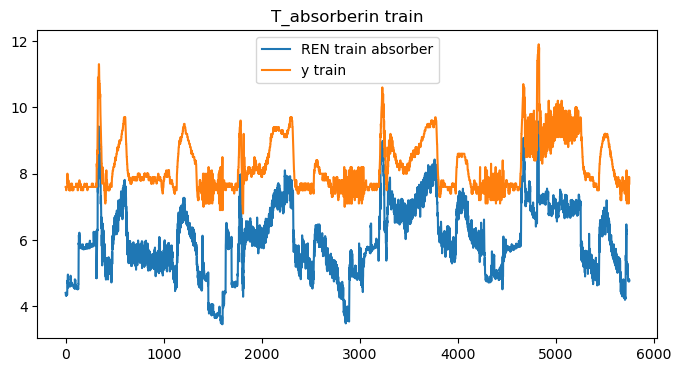

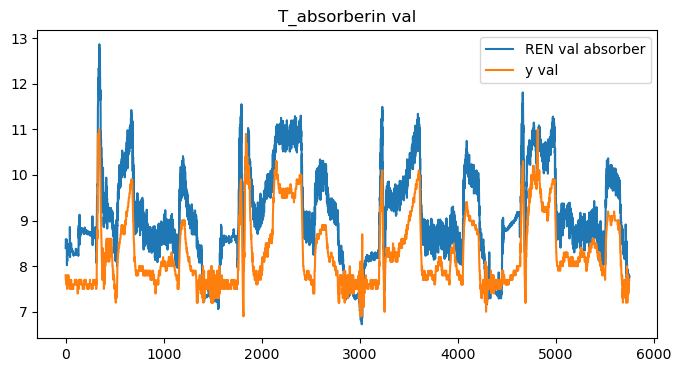

Loss Validation single REN absorber: 0.003360886126756668


In [ ]:
yval = torch.from_numpy(Toutass_v[1 * 1440: + 5* 1440]).float().to(device) #Toutass
yval = yval.T

yRENm_val = torch.zeros(p, t_end, device=device, dtype=dtype)
yRENm_val[:,0] = yval[:,0]
xiVal = torch.randn(n_xi)
dval = torch.cat(( torch.from_numpy(yExp_val[0,0][1* 1440 +1:5* 1440,0]).float().to(device).unsqueeze(1), #T_rit
                    torch.from_numpy(dExp_val[0, 0][1* 1440 +1:5* 1440,-1]).float().to(device).unsqueeze(1)), dim=1) # Qabs
dval= dval.T
loss_val = 0
for t in range(1, t_end):
    yRENm_val[:, t], xiVal = RENsys(dval[:,t-1], xiVal, t)
loss_val = loss_val + MSE(yRENm_val[:, 0:yRENm_val.size(1)], yval[:, 0:t_end + 1])

loss_val_REN = loss_val

plt.figure(figsize=(4 * 2, 4))
for out in range(p):
    plt.subplot(1, p, out+1)
    plt.plot(maxTabs.squeeze()*yRENm[out, 10:t_end].detach().numpy(), label='REN train absorber')
    plt.plot(maxTabs.squeeze()*y[out, 10:t_end].detach().numpy(), label='y train')
    plt.title(r"T_absorber" + r"in train")  
    plt.legend()
plt.show()

plt.figure(figsize=(4 * 2, 4))
for out in range(p):
    plt.subplot(1, p, out+1)
    plt.plot(maxTabs.squeeze()*yRENm_val[out, 10:t_end].detach().numpy(), label='REN val absorber')
    plt.plot(maxTabs.squeeze()*yval[out, 10:t_end].detach().numpy(), label='y val')
    plt.title(r"T_absorber" + r"in val")  
    plt.legend()
plt.show()

pytorch_total_params_singleREN = sum(p.numel() for p in RENsys.parameters() if p.requires_grad)
print(f"Loss Validation single REN absorber: {loss_val_REN}")

# Save
torch.save({
    'epoch': epoch,
    'model_state_dict': RENsys.state_dict(),
    'loss': loss,
}, f'checkpoint_2moredays_absorber_epoch_{epoch+1}.pth')

# Chillers

Epoch: 1 	||	 Loss: 0.006252171937376261
L2 gain REN: 1
Epoch: 2 	||	 Loss: 0.0011025029234588146
L2 gain REN: 1
Epoch: 3 	||	 Loss: 0.006883347872644663
L2 gain REN: 1
Epoch: 4 	||	 Loss: 0.0031673612538725138
L2 gain REN: 1
Epoch: 5 	||	 Loss: 0.0008446714491583407
L2 gain REN: 1


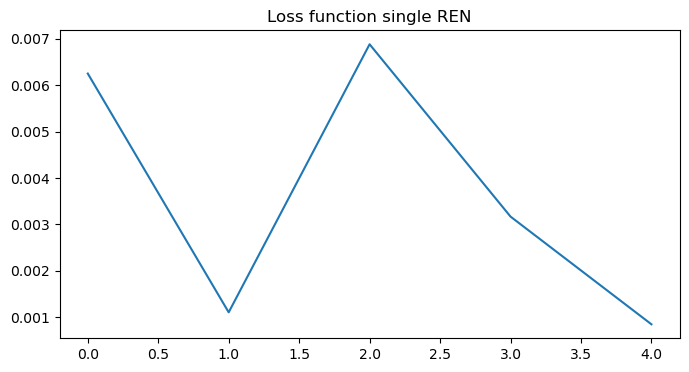

In [ ]:
# Train single REN CHILLERS more exp
epochs = 2
t_end = 2*1440

n = 2  # input dimensions
p = 1  # output dimensions

n_xi = 20# nel paper n1, numero di stati
l = 20   # nel paper q, dimension of the square matrix D11 -- number of _non-linear layers_ of the RE
# Define the model
RENsys = REN(n, p, n_xi, l, gammaTrain = False, gamma=1)
# Define Loss function
MSE = nn.MSELoss()
# Define Optimization method
learning_rate = 1.0e-1
optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
optimizer.zero_grad()

LOSS = np.zeros(epochs)

for epoch in range(epochs):
    if epoch == epochs - epochs / 2:
        learning_rate = 1.0e-2
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    if epoch == epochs - epochs / 6:
        learning_rate = 1.0e-3
        optimizer = torch.optim.Adam(RENsys.parameters(), lr=learning_rate)
    optimizer.zero_grad()
    loss = 0
    for exp in range(3*nExp):
        y = torch.from_numpy(Toutchill_t[exp*10080 +3 * 1440:exp*10080 + 5* 1440]).float().to(device) #Toutchill
        y = y.T
        yRENm = torch.randn(p, t_end, device=device, dtype=dtype)
        yRENm[:,0] = y[:,0]
        xi = torch.randn(n_xi)
        d = torch.cat(( torch.from_numpy(yExp[0, int(np.floor(exp/3))][(exp%3)*10080 + 3* 1440 +1: (exp%3)*10080 + 5* 1440,0]).float().to(device).unsqueeze(1), #Trit
                        torch.from_numpy(dExp[0, int(np.floor(exp/3))][(exp%3)*10080 + 3* 1440 +1: (exp%3)*10080 + 5* 1440,-2]).float().to(device).unsqueeze(1)), dim=1)#I/O chillers
                       
        d = d.T
        for t in range(1, t_end):
            #u = torch.tensor([d[inputnumberD, t]])
            yRENm[:, t], xi = RENsys(d[:,t-1], xi, t)
        loss = loss + MSE(yRENm[:, 0:yRENm.size(1)], y[:, 0:t_end + 1])
        # ignorare da loss effetto condizione iniziale

    loss = loss / 3/nExp
    #loss.backward()
    loss.backward(retain_graph=True)

    optimizer.step()
    RENsys.set_param()

    print(f"Epoch: {epoch + 1} \t||\t Loss: {loss}")
    print(f"L2 gain REN: {RENsys.gamma}")
    LOSS[epoch] = loss

plt.figure(figsize=(4 * 2, 4))
plt.plot(LOSS)
plt.title("Loss function single REN")
plt.show()


In [ ]:
yval = torch.from_numpy(Toutchill_v[3* 1440 +1:5* 1440]).float().to(device) #Toutchill
yval = yval.T

yRENm_val = torch.zeros(p, t_end, device=device, dtype=dtype)
yRENm_val[:,0] = yval[:,0]
xiVal = torch.randn(n_xi)
dval = torch.cat(( torch.from_numpy(yExp_val[0, 0][3* 1440 +1:5* 1440,0]).float().to(device).unsqueeze(1), #Trit
                        torch.from_numpy(dExp_val[0, 0][3* 1440 +1:5* 1440,-2]).float().to(device).unsqueeze(1)), dim=1)#I/O chillers
dval = dval.T
loss_val = 0
for t in range(1, t_end):
    yRENm_val[:, t], xiVal = RENsys(dval[:,t-1], xiVal, t)
loss_val = loss_val + MSE(yRENm_val[:, :], yval[:, :])

loss_val_REN = loss_val

plt.figure(figsize=(4 * 2, 4))
for out in range(p):
    plt.subplot(1, p, out+1)
    plt.plot(maxTchill.squeeze()*yRENm[out,:].detach().numpy(), label='REN train chillers')
    plt.plot(maxTchill.squeeze()*y[out, 0:t_end].detach().numpy(), label='y train')
    plt.title("T_chillers output in train")  
plt.show()

plt.figure(figsize=(4 * 2, 4))
for out in range(p):
    plt.subplot(1, p, out+1)
    plt.plot(maxTchill.squeeze()*yRENm_val[out, 0:t_end].detach().numpy(), label='REN val chillers')
    plt.plot(maxTchill.squeeze()*yval[out, 0:t_end].detach().numpy(), label='y val')
    plt.title("T_chillers output in val")  
    plt.legend()
plt.show()

pytorch_total_params_singleREN = sum(p.numel() for p in RENsys.parameters() if p.requires_grad)
print(f"Loss Validation single REN chillers: {loss_val_REN}")

# Save
torch.save({
    'epoch': epoch,
    'model_state_dict': RENsys.state_dict(),
    'loss': loss,
}, f'checkpoint_moreexp_chillers_epoch_{epoch+1}.pth')


c:\Users\adela\anaconda3\envs\tf_env\lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1, 2879])) that is different to the input size (torch.Size([1, 2880])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (2880) must match the size of tensor b (2879) at non-singleton dimension 1